## Demo for project 1

In [1]:
import torch
import torchvision

c:\Users\admin\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define dataset and dataloader

In [2]:
%load_ext autoreload
%autoreload 2

from dataset import load_dataset

trainset, valset = load_dataset(train=True)
testset = load_dataset(train=False)

batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 100/100 [00:00<00:00, 50357.83it/s]


### Check dataset and dataloader

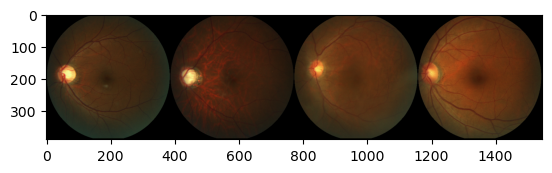

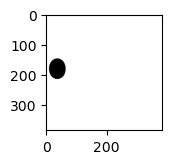

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # The data need to be normalized and unnormalized to keep the same
    # img = img / 255
    # img = img / 2 + 0.5     # unnormalize

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))[:,:,::-1])
    plt.show()

# get some random training images
dataiter = iter(valloader)
images, targets, names = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print(names)
target_last = targets.numpy()[-1,:,:]
plt.figure(figsize=[1.5,1.5])
plt.imshow(target_last,cmap='gray')

### Domain generalization example.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Domain generalization example: random.')

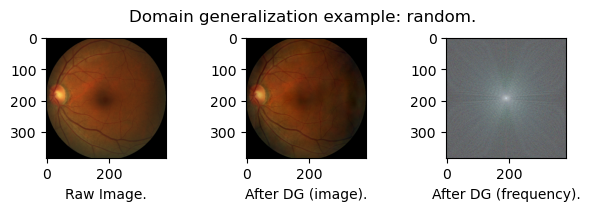

In [4]:
from dataset import domain_generization
# last image of trainning set
original_random_image = images.numpy()[-1]
scaling_factor = 0.1 # 替换低频区域所占大小
ratio =0.5 #替换区域中目标域图片的幅度比重 
num_generalized=2
domain = 'random' # 可选：'random'（默认）, 'domain1', 'domain2', 'domain3'.
dg_outputs, dg_fre_outputs= np.array(domain_generization(original_random_image,scaling_factor, 
ratio,num_generalized,domain)) # 输出是一个float, 因为计算傅里叶变换的时候应该用float提高精度
dg_output = dg_outputs[0]
dg_fre_output = dg_fre_outputs[0]
dg_fre_output = np.log(np.abs(dg_fre_output))/np.max(np.log(np.abs(dg_fre_output))) # log and normalize
fig, axs = plt.subplots(1, 3, figsize=(6, 2), layout="constrained")
axs[0].imshow(np.transpose(original_random_image, (1, 2, 0))[:,:,::-1])
axs[0].set_xlabel('Raw Image.')
axs[1].imshow(np.transpose(np.real(dg_output).astype(int), (1, 2, 0))[:,:,::-1]) # 转回int才可以直接imshow
axs[1].set_xlabel('After DG (image).')
axs[2].imshow(np.transpose(dg_fre_output,(1,2,0)),cmap='gray')
axs[2].set_xlabel('After DG (frequency).')
plt.suptitle('Domain generalization example: {}.'.format(domain))

### Question 1 

In [5]:
# Generalize a source image to three domains.
original_image, _ = trainset.__getitem__(0) # Use the first image in training set.

### Define a model

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

net = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)
print(net)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Define loss function and optimizer

In [7]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train network

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (inputs, target) in enumerate(trainloader):
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimizeo 
        # change the data to float type
        outputs = net(inputs.to(torch.float32))
        # print((outputs.shape))
        # print(target.to(torch.float32).dtype)
        loss = criterion(outputs, target.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

print('Finished Training')



[1,    20] loss: 0.778
[2,    20] loss: 0.158
Finished Training


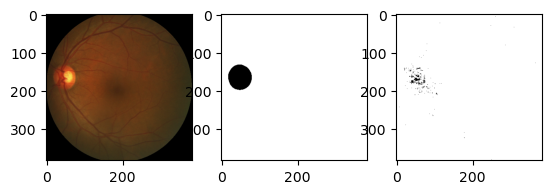

In [9]:
# show last valiadated result
input = inputs.numpy()[-1]
output_np = torch.argmax(outputs[-1], dim=0).cpu().numpy()
plt.subplot(1,3,1)
plt.imshow(np.transpose(input,(1,2,0))[:,:,::-1])
plt.subplot(1,3,2)
plt.imshow(target[-1,:,:],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(output_np,cmap='gray')
plt.show()

### Save model

In [10]:
PATH = './net.pth'
torch.save(net.state_dict(), PATH)

### Test your model performance

In [11]:
from sklearn.metrics import accuracy_score, f1_score

nclasses = 2

net = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=nclasses,                      # model output channels (number of classes in your dataset)
)

net.load_state_dict(torch.load(PATH))
dscs = []

with torch.no_grad():
    for data in testloader:
        images, targets, names = data
        
        outputs = net(images.to(torch.float32))
        
        for idx, name in enumerate(names):
            output_np = torch.argmax(outputs[idx], dim=0).cpu().numpy()
            binary_output = np.array(output_np)
            target_np = targets[idx].cpu().numpy().astype(np.uint8)
            
            target_1d = np.reshape(target_np, (-1, 1))
            pred_1d = np.reshape(binary_output, (-1, 1))
            accuracy = accuracy_score(target_1d, pred_1d)
            if nclasses == 2:
                dsc = f1_score(target_1d, pred_1d)
            else:
                dsc = f1_score(target_1d, pred_1d,average='micro')
            dscs.append(dsc)

dsc_test = np.mean(dscs)
print('Dsc of test set:', dsc_test)

Dsc of test set: 0.9912130636371183


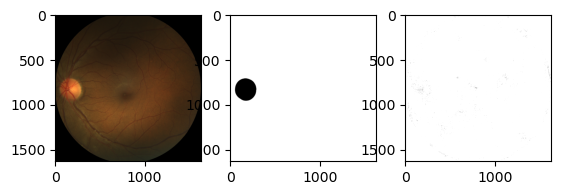

In [12]:
# show last predicted result
image = images.numpy()[-1]
output = outputs.numpy()[-1,:,:,:]
plt.subplot(1,3,1)
plt.imshow(np.transpose(image,(1,2,0))[:,:,::-1])
plt.subplot(1,3,2)
plt.imshow(target_np,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(binary_output,cmap='gray')
plt.show()